# Heuristic

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import time

In [5]:
class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            [p for p in self.polygons if p != self.storage_polygon],
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                    
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY,
                    int((max_planting_minutes - planting_minutes_used - delivery_time) * (self.PLANTS_PER_HOUR / 60))
                )
                
                if plant_qty <= 0:
                    continue
                    
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_time = plant_qty / self.PLANTS_PER_HOUR * 60
                planting_minutes_used += delivery_time + planting_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins, planting: {planting_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()
    

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins, planting: 48.0 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins, planting: 48.0 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins, planting: 48.0 mins)
Day 1: Total treated and planted today: 240/1200
Storage: 6160/6400
Total planted: 240

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins, planting: 48.0 mins)
Day 2: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins, planting: 48.0 mins)
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins, planting: 48.0 mins)
Day 2: Total treated and planted today: 240/1200
Storage: 5920/6400
Total planted: 480

=== Day 3 ===
Day 3: 240 E9 plants arrived in storage
Day

In [1]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No arrivals processed (Sunday)")
            return
        
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting (Sunday)")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            [p for p in self.polygons if p != self.storage_polygon],
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0 or planting_minutes_used >= max_planting_minutes:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY,
                    int((max_planting_minutes - planting_minutes_used - delivery_time) * (self.PLANTS_PER_HOUR / 60))
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_time = 0  # Planting time is considered as 0 minutes
                planting_minutes_used += delivery_time + planting_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins, planting: {planting_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins, planting: 0 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins, planting: 0 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins, planting: 0 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins, planting: 0 mins)
Day 1: Treated and planted 7 E2 at P4 (delivery: 74.982096 mins, planting: 0 mins)
Day 1: Total treated and planted today: 327/1200
Storage: 6073/6400
Total planted: 327

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins, planting: 0 mins)
Day 2: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins, planting: 0 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins, planting: 0 m

In [2]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No arrivals processed (Sunday)")
            return
        
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting (Sunday)")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            [p for p in self.polygons if p != self.storage_polygon],
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2:

# Pretty

In [3]:
import time
import pandas as pd
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No arrivals processed (Sunday)")
            return
        
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting (Sunday)")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            [p for p in self.polygons if p != self.storage_polygon],
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

        # Final balance of plants planted per polygon
        final_balance = []
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                final_balance.append({
                    'polygon': p,
                    'plant_type': pt,
                    'planted': planted
                })
        
        final_balance_df = pd.DataFrame(final_balance)
        final_balance_df.to_csv('final_balance.csv', index=False)
        print("Saved final balance to final_balance.csv")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2:

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2:

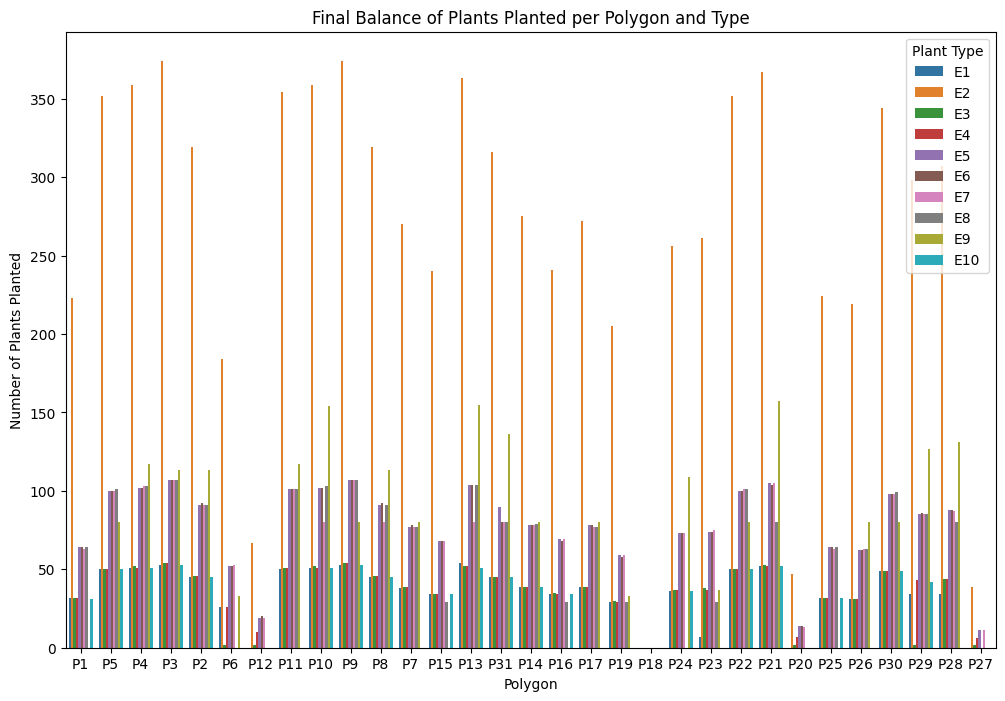

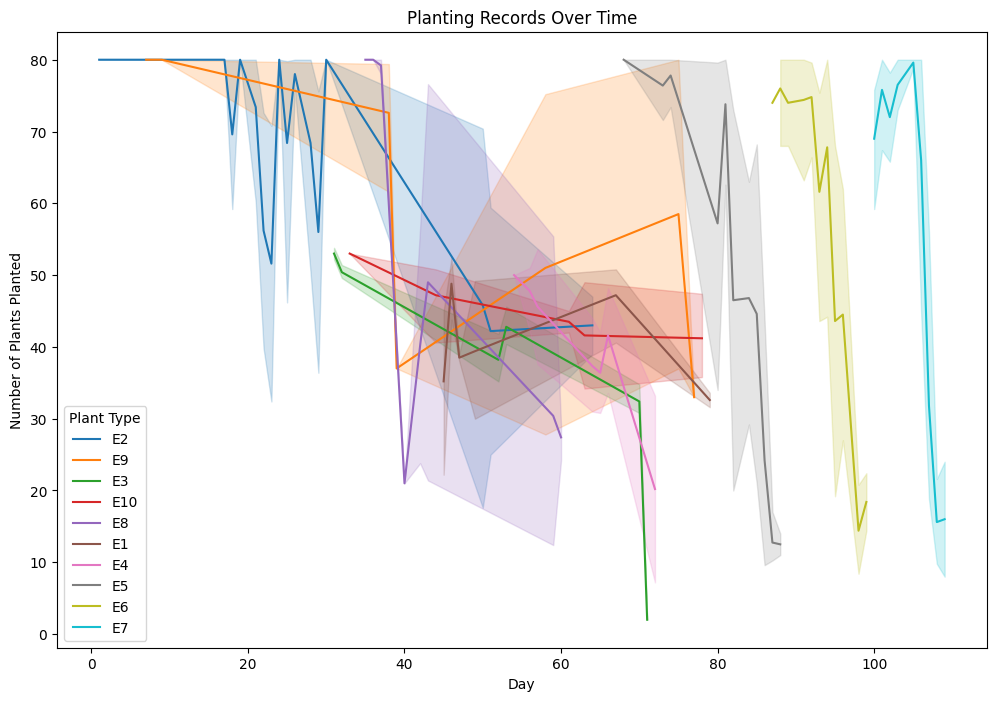

In [4]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No arrivals processed (Sunday)")
            return
        
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting (Sunday)")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            [p for p in self.polygons if p != self.storage_polygon],
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files and generate visualizations"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

        # Final balance of plants planted per polygon
        final_balance = []
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                final_balance.append({
                    'polygon': p,
                    'plant_type': pt,
                    'planted': planted
                })
        
        final_balance_df = pd.DataFrame(final_balance)
        final_balance_df.to_csv('final_balance.csv', index=False)
        print("Saved final balance to final_balance.csv")

        # Generate visualizations
        self.generate_visualizations()

    def generate_visualizations(self):
        """Generate visualizations for the final balance and other relevant data"""
        print("\nGenerating visualizations...")

        # Read final balance data
        final_balance_df = pd.read_csv('final_balance.csv')

        # Plot final balance of plants planted per polygon and type
        plt.figure(figsize=(12, 8))
        sns.barplot(x='polygon', y='planted', hue='plant_type', data=final_balance_df)
        plt.title('Final Balance of Plants Planted per Polygon and Type')
        plt.xlabel('Polygon')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Plant Type')
        plt.savefig('final_balance.png')
        print("Saved final balance visualization to final_balance.png")

        # Read planting records
        planting_df = pd.read_csv('heuristic_planting.csv')

        # Plot planting records over time
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='day', y='quantity', hue='plant_type', data=planting_df)
        plt.title('Planting Records Over Time')
        plt.xlabel('Day')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Plant Type')
        plt.savefig('planting_records.png')
        print("Saved planting records visualization to planting_records.png")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()

Running heuristic solution...
Loading data...
Loaded data for 31 polygons, 10 plant types

=== Day 0 ===
Day 0: No plants to treat
Storage: 0/6400
Total planted: 0

=== Day 1 ===
Day 1: 6400 E2 plants arrived in storage
Day 1: Treated and planted 80 E2 at P3 (delivery: 73.998096 mins)
Day 1: Treated and planted 80 E2 at P9 (delivery: 73.476912 mins)
Day 1: Treated and planted 80 E2 at P21 (delivery: 66.819504 mins)
Day 1: Treated and planted 80 E2 at P13 (delivery: 66.382224 mins)
Day 1: Treated and planted 80 E2 at P4 (delivery: 74.982096 mins)
Day 1: Total treated and planted today: 400/1200
Storage: 6000/6400
Total planted: 400

=== Day 2 ===
Day 2: Treated and planted 80 E2 at P10 (delivery: 74.46091200000001 mins)
Day 2: Treated and planted 80 E2 at P11 (delivery: 74.428944 mins)
Day 2: Treated and planted 80 E2 at P22 (delivery: 65.81952 mins)
Day 2: Treated and planted 80 E2 at P5 (delivery: 74.95008 mins)
Day 2: Treated and planted 80 E2 at P30 (delivery: 63.224832 mins)
Day 2:

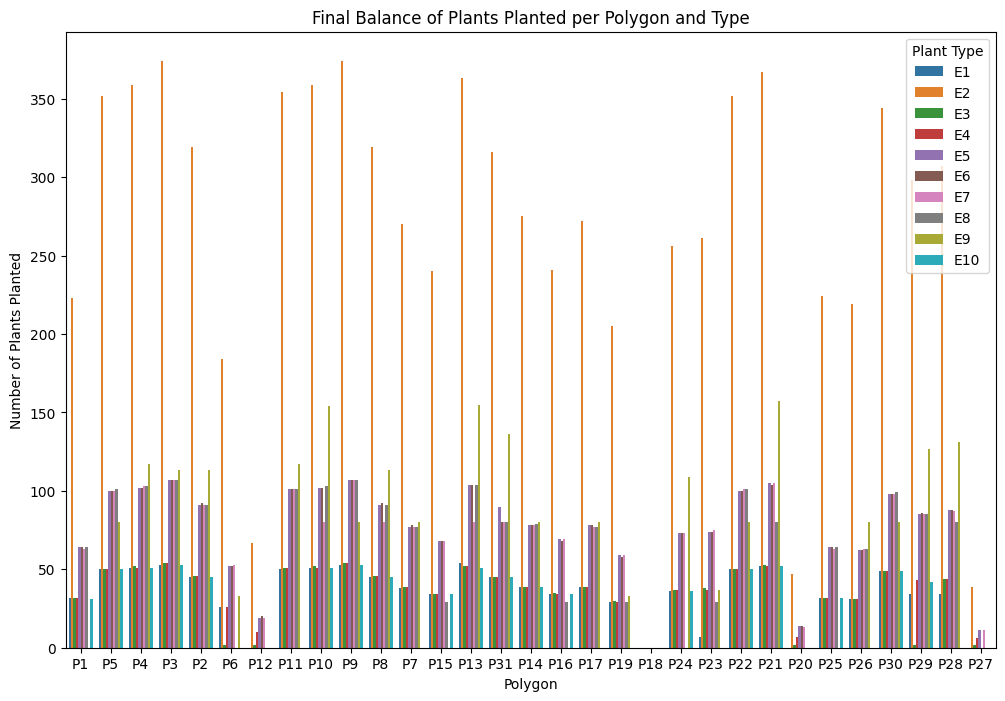

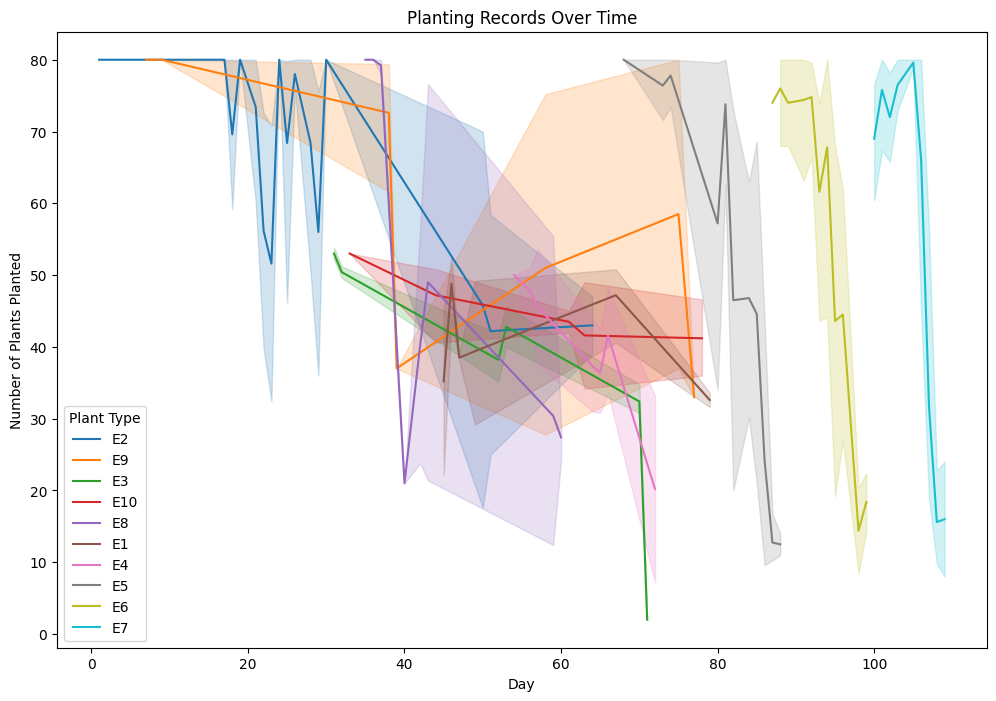

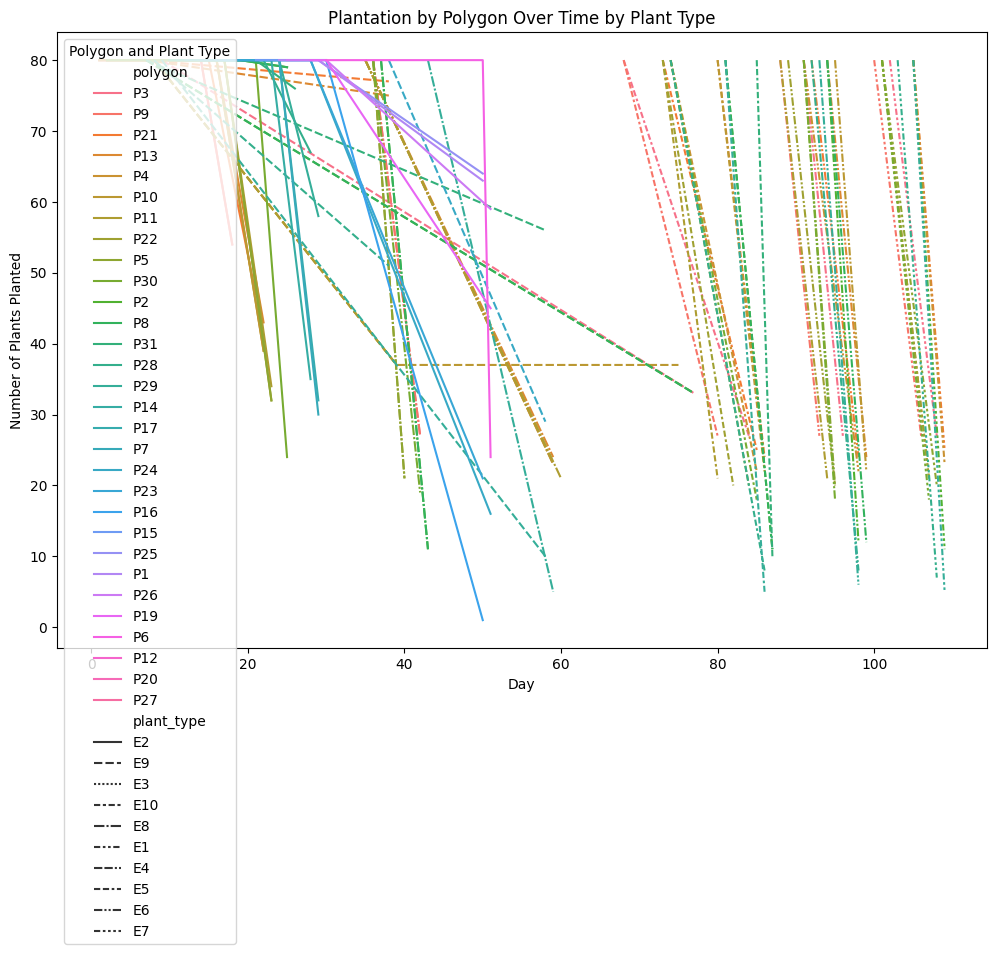

In [5]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

class ReforestationHeuristic:
    def __init__(self):
        # Constants
        self.PLANT_HA_EQUIVALENT = 0.0069
        self.MIN_PLANTS_WEEKDAY = 725  # 5ha
        self.MIN_PLANTS_SATURDAY = 0
        self.WORK_HOURS_WEEKDAY = 6
        self.WORK_HOURS_SATURDAY = 3
        self.PLANTING_COST_PER_PLANT = 20
        self.NURSERY_TRUCK_COST = 4500
        self.DELIVERY_TRUCK_COST = 0
        self.NURSERY_TRUCK_CAPACITY = 8000
        self.ORDER_LEAD_TIME = 1
        self.STORAGE_CAPACITY = 6400
        self.TREATMENT_CAPACITY = 1200  # Max plants that can be treated per day
        self.DELIVERY_TRUCK_CAPACITY = 80
        self.PLANTS_PER_HOUR = 100
        self.PLANTING_START_DAY = 3  # Can plant from day 3 after arrival
        self.PLANTING_END_DAY = 7    # Must plant by day 7 after arrival
        self.DAYS = 225

    def load_data(self):
        """Load and validate all input data"""
        print("Loading data...")
        try:
            self.distance_matrix = pd.read_csv('distance_times.csv', index_col=0)
            self.plantas_pol = pd.read_csv('plantas_pol.csv', index_col=0)
            self.plantas_vivero = pd.read_csv('Plantas_vivero.csv')
            self.plantas_vol = pd.read_csv('Plantas_vol.csv')
            
            try:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant_Type')
            except:
                self.survival_rates = pd.read_csv('Plantas_supervivencia.csv', index_col='Plant Type')
            
            # Validate data
            self.polygons = self.distance_matrix.index.tolist()
            self.storage_polygon = 'P18'
            self.nurseries = ['V1', 'V2', 'V3', 'V4']
            self.plant_types = [pt for pt in self.plantas_pol.index 
                              if (pt in self.survival_rates.index and
                                  not self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt].empty and
                                  not self.plantas_vol[self.plantas_vol['Plant Type'] == pt].empty)]
            
            print(f"Loaded data for {len(self.polygons)} polygons, {len(self.plant_types)} plant types")
            
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def initialize_structures(self):
        """Initialize data structures for tracking"""
        # Requirements - now tracking per polygon and species
        self.plant_requirements = defaultdict(dict)
        for p in self.plantas_pol.columns:
            for pt in self.plant_types:
                self.plant_requirements[p][pt] = self.plantas_pol.loc[pt, p]
        
        # Nursery costs
        self.nursery_costs = {}
        for n in self.nurseries:
            self.nursery_costs[n] = {}
            for pt in self.plant_types:
                cost = self.plantas_vivero[self.plantas_vivero['Plant Type'] == pt][n].values[0]
                self.nursery_costs[n][pt] = cost if not np.isnan(cost) else 999999
        
        # Tracking structures
        self.storage = defaultdict(int)          # Current plants in storage
        self.in_transit = defaultdict(list)      # Plants ordered but not yet arrived
        self.ready_for_planting = []             # Plants ready to be planted (treated) - must be planted same day
        
        # Results tracking
        self.orders = []
        self.plantings = []
        self.total_cost = 0
        self.total_planted = 0
        self.planted_per_polygon = defaultdict(lambda: defaultdict(int))  # Track planted per polygon per species

    def get_day_type(self, day):
        """Return day type and available working hours"""
        day_of_week = day % 7
        if day_of_week == 5:  # Saturday
            return 'saturday', self.WORK_HOURS_SATURDAY
        elif day_of_week == 6:  # Sunday
            return 'sunday', 0
        else:
            return 'weekday', self.WORK_HOURS_WEEKDAY

    def order_plants(self, day):
        """Improved ordering logic to maintain continuous workflow"""
        current_storage = sum(self.storage.values())
        available_space = self.STORAGE_CAPACITY - current_storage
        
        if available_space <= 0:
            return
        
        # Calculate remaining needs per species across all polygons
        remaining_needs = defaultdict(int)
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                remaining_needs[pt] += max(0, self.plant_requirements[p].get(pt, 0) - planted)
        
        # Subtract what's already in storage or in transit
        for pt in self.plant_types:
            remaining_needs[pt] = max(0, remaining_needs[pt] - self.storage.get(pt, 0) - 
                                   sum(qty for (arr_day, pt2, qty) in self.in_transit[pt] if pt2 == pt))
        
        # Calculate expected planting rate (average of last 7 days)
        recent_plantings = [p['quantity'] for p in self.plantings if p['day'] >= day - 7]
        avg_daily_planting = sum(recent_plantings)/7 if recent_plantings else 100
        
        # Order enough plants to maintain workflow for next 7 days
        for pt in sorted(remaining_needs.keys(), key=lambda x: remaining_needs[x], reverse=True):
            if remaining_needs[pt] <= 0 or available_space <= 0:
                continue
                
            # Find cheapest available nursery
            best_nursery = None
            best_cost = float('inf')
            for n in self.nurseries:
                cost = self.nursery_costs[n].get(pt, 99999)
                if cost < best_cost:
                    best_nursery = n
                    best_cost = cost
            
            if best_nursery is None:
                continue
                
            # Determine order quantity - enough for 7 days of planting
            order_qty = min(
                remaining_needs[pt],
                self.NURSERY_TRUCK_CAPACITY,
                available_space,
                max(avg_daily_planting * 7, self.NURSERY_TRUCK_CAPACITY)  # At least one truckload
            )
            
            if order_qty <= 0:
                continue
                
            # Make the order
            self.orders.append({
                'day': day,
                'nursery': best_nursery,
                'plant_type': pt,
                'quantity': order_qty,
                'arrival_day': day + self.ORDER_LEAD_TIME
            })
            
            # Update tracking
            self.in_transit[pt].append((day + self.ORDER_LEAD_TIME, pt, order_qty))
            self.total_cost += order_qty * best_cost + self.NURSERY_TRUCK_COST
            available_space -= order_qty

    def process_arrivals(self, day):
        """Process plant arrivals into storage with overflow handling"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No arrivals processed (Sunday)")
            return
        
        for pt in list(self.in_transit.keys()):
            new_arrivals = []
            arrived = 0
            
            for arrival in self.in_transit[pt]:
                arr_day, arr_pt, qty = arrival
                if arr_day == day:
                    # Check storage capacity before adding
                    if sum(self.storage.values()) + qty <= self.STORAGE_CAPACITY:
                        self.storage[arr_pt] += qty
                        arrived += qty
                    else:
                        # Accept partial delivery if possible
                        space_left = self.STORAGE_CAPACITY - sum(self.storage.values())
                        if space_left > 0:
                            partial_qty = min(space_left, qty)
                            self.storage[arr_pt] += partial_qty
                            arrived += partial_qty
                            remaining_qty = qty - partial_qty
                            if remaining_qty > 0:
                                new_arrivals.append((arr_day, arr_pt, remaining_qty))
                                print(f"Day {day}: Could only accept {partial_qty} of {qty} {pt} plants due to storage limits")
                        else:
                            new_arrivals.append(arrival)
                            print(f"Day {day}: Storage full, couldn't accept {qty} {pt} plants")
                else:
                    new_arrivals.append(arrival)
            
            self.in_transit[pt] = new_arrivals
            
            if arrived > 0:
                print(f"Day {day}: {arrived} {pt} plants arrived in storage")

    def treat_and_plant_plants(self, day):
        """Combined treatment and planting to ensure plants are planted same day they're treated"""
        day_type, max_hours = self.get_day_type(day)
        if day_type == 'sunday':
            print(f"Day {day}: No planting (Sunday)")
            return
            
        max_planting_minutes = max_hours * 60
        planting_minutes_used = 0
        
        # Calculate how many plants we can treat today (limited by treatment capacity)
        total_to_treat = min(
            sum(self.storage.values()),
            self.TREATMENT_CAPACITY
        )
        
        if total_to_treat <= 0:
            print(f"Day {day}: No plants to treat")
            return
            
        # Sort polygons by remaining needs (most needed first)
        polygons_sorted = sorted(
            [p for p in self.polygons if p != self.storage_polygon],
            key=lambda x: sum(
                max(0, self.plant_requirements[x].get(pt, 0) - self.planted_per_polygon[x].get(pt, 0))
                for pt in self.plant_types
            ),
            reverse=True
        )
        
        # Sort plant types in storage by priority (oldest first, then most needed)
        plant_types_in_storage = []
        for pt in self.storage:
            if self.storage[pt] > 0:
                # Find earliest arrival day for this plant type
                arrival_days = [arr[0] for arr in self.in_transit[pt] if arr[0] <= day]
                earliest_arrival = min(arrival_days) if arrival_days else day
                plant_types_in_storage.append((earliest_arrival, pt))
        
        plant_types_in_storage.sort()
        
        # Process plants for treatment and immediate planting
        treated_today = 0
        remaining_treatment_capacity = total_to_treat
        
        for arrival_day, pt in plant_types_in_storage:
            if remaining_treatment_capacity <= 0:
                break
                
            available = min(self.storage[pt], remaining_treatment_capacity)
            if available <= 0:
                continue
                
            # Find polygons that need this plant type
            for p in polygons_sorted:
                if remaining_treatment_capacity <= 0:
                    break
                    
                remaining_need = max(0, self.plant_requirements[p].get(pt, 0) - self.planted_per_polygon[p].get(pt, 0))
                if remaining_need <= 0:
                    continue
                    
                # Calculate delivery time
                delivery_time = 60 + 2 * self.distance_matrix.loc[self.storage_polygon, p]
                
                if planting_minutes_used + delivery_time > max_planting_minutes:
                    continue
                
                # Determine how many we can plant here
                plant_qty = min(
                    remaining_need,
                    available,
                    self.DELIVERY_TRUCK_CAPACITY
                )
                
                if plant_qty <= 0:
                    continue
                
                # "Treat" and plant immediately
                self.storage[pt] -= plant_qty
                treated_today += plant_qty
                remaining_treatment_capacity -= plant_qty
                
                # Record planting
                self.plantings.append({
                    'day': day,
                    'polygon': p,
                    'plant_type': pt,
                    'quantity': plant_qty
                })
                
                self.total_planted += plant_qty
                self.planted_per_polygon[p][pt] += plant_qty
                self.total_cost += plant_qty * self.PLANTING_COST_PER_PLANT + self.DELIVERY_TRUCK_COST
                
                planting_minutes_used += delivery_time
                
                print(f"Day {day}: Treated and planted {plant_qty} {pt} at {p} (delivery: {delivery_time} mins)")
        
        print(f"Day {day}: Total treated and planted today: {treated_today}/{total_to_treat}")

    def run_heuristic(self):
        """Run the complete heuristic solution"""
        print("Running heuristic solution...")
        start_time = time.time()
        
        self.load_data()
        self.initialize_structures()
        
        for day in range(self.DAYS):
            print(f"\n=== Day {day} ===")
            
            # Daily process
            self.process_arrivals(day)
            self.order_plants(day)
            self.treat_and_plant_plants(day)  # Combined treatment and planting
            
            # Print daily summary
            print(f"Storage: {sum(self.storage.values())}/{self.STORAGE_CAPACITY}")
            print(f"Total planted: {self.total_planted}")
            
            # Check if all requirements are met
            all_met = True
            for p in self.polygons:
                for pt in self.plant_types:
                    req = self.plant_requirements[p].get(pt, 0)
                    planted = self.planted_per_polygon[p].get(pt, 0)
                    if planted < req:
                        all_met = False
                        break
                if not all_met:
                    break
            
            if all_met:
                print("\nAll plants have been planted!")
                break
        
        # Final report
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        completion = (self.total_planted / total_required) * 100 if total_required > 0 else 0
        
        print("\n=== Heuristic Solution Complete ===")
        print(f"Total Cost: ${self.total_cost:,.2f}")
        print(f"Plants Planted: {self.total_planted:,} of {total_required:,}")
        print(f"Completion: {completion:.1f}%")
        print(f"Runtime: {time.time() - start_time:.2f} seconds")
        
        self.save_results()

    def save_results(self):
        """Save results to CSV files and generate visualizations"""
        print("\nSaving results...")
        
        # Orders
        orders_df = pd.DataFrame(self.orders)
        if not orders_df.empty:
            orders_df.to_csv('heuristic_orders.csv', index=False)
            print(f"Saved {len(orders_df)} orders to heuristic_orders.csv")
        
        # Plantings
        planting_df = pd.DataFrame(self.plantings)
        if not planting_df.empty:
            planting_df.to_csv('heuristic_planting.csv', index=False)
            print(f"Saved {len(planting_df)} planting records to heuristic_planting.csv")
        
        # Summary
        total_required = sum(sum(p.values()) for p in self.plant_requirements.values())
        summary = {
            'total_cost': self.total_cost,
            'total_planted': self.total_planted,
            'total_required': total_required,
            'completion_percentage': (self.total_planted / total_required) * 100 if total_required > 0 else 0
        }
        pd.DataFrame([summary]).to_csv('heuristic_summary.csv', index=False)
        print("Saved summary to heuristic_summary.csv")

        # Final balance of plants planted per polygon
        final_balance = []
        for p in self.polygons:
            for pt in self.plant_types:
                planted = self.planted_per_polygon[p].get(pt, 0)
                final_balance.append({
                    'polygon': p,
                    'plant_type': pt,
                    'planted': planted
                })
        
        final_balance_df = pd.DataFrame(final_balance)
        final_balance_df.to_csv('final_balance.csv', index=False)
        print("Saved final balance to final_balance.csv")

        # Generate visualizations
        self.generate_visualizations()

    def generate_visualizations(self):
        """Generate visualizations for the final balance and other relevant data"""
        print("\nGenerating visualizations...")

        # Read final balance data
        final_balance_df = pd.read_csv('final_balance.csv')

        # Plot final balance of plants planted per polygon and type
        plt.figure(figsize=(12, 8))
        sns.barplot(x='polygon', y='planted', hue='plant_type', data=final_balance_df)
        plt.title('Final Balance of Plants Planted per Polygon and Type')
        plt.xlabel('Polygon')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Plant Type')
        plt.savefig('final_balance.png')
        print("Saved final balance visualization to final_balance.png")

        # Read planting records
        planting_df = pd.read_csv('heuristic_planting.csv')

        # Plot planting records over time
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='day', y='quantity', hue='plant_type', data=planting_df)
        plt.title('Planting Records Over Time')
        plt.xlabel('Day')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Plant Type')
        plt.savefig('planting_records.png')
        print("Saved planting records visualization to planting_records.png")

        # Plot plantation by polygon over time, broken down by plant type
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='day', y='quantity', hue='polygon', style='plant_type', data=planting_df)
        plt.title('Plantation by Polygon Over Time by Plant Type')
        plt.xlabel('Day')
        plt.ylabel('Number of Plants Planted')
        plt.legend(title='Polygon and Plant Type')
        plt.savefig('plantation_by_polygon_over_time.png')
        print("Saved plantation by polygon over time visualization to plantation_by_polygon_over_time.png")

if __name__ == "__main__":
    solver = ReforestationHeuristic()
    solver.run_heuristic()